# Deep Learning Based Face Swap Tutorial

April 23, 2021. v0.2.0

# Intro

Generating images or videos by manipulating facial attributes (i.e. face reenactment and swapping) has gained a lot of attention in recent years due to their broad range of computer vision and multimedia applications such as video dubbing, gaze correction, actor capturing, and virtual avatar creation. Imagine, old Mark Hamill could act as a young Luke Skywalker, or a stuntman acting as Daniel Craig. In this tutorial, you will play with a face swapping pipeline based on 2D-to-3D reconstruction.

The task of face reenactment is to change attribute of a face image (i.e. pose, expression or light), while *face swapping* is focused on changing face identity of an image while keeping other attributes (pose, expression and background) the same. Face identity can be defined as a set of attributes which identifies a person. It can range from a skin / eye colors to face geometry and expression. Ignoring geometrical changes and lighting condition, one can approximate facial identity purely by a texture of the face region.

# Environment preparation

Before everything, please add a shortcut to this Google Drive directory: https://drive.google.com/drive/folders/1EEdqNgK8xN-gqJO5-NLv4PGH5_dU7zna?usp=sharing

Download BFM 2009 model from here https://faces.dmi.unibas.ch/bfm/index.php?nav=1-2&id=downloads (BFM 2009 used in this part of the assignment is different from BFM 2017 used in the other part).

In [1]:
## Mounts Google drive
from google.colab import drive
drive.mount('/content/gdrive')
%tensorflow_version 2.x
!pip uninstall -y tensorflow
!pip install tensorflow==1.13.1
!pip install tensorflow-gpu==1.13.1

Mounted at /content/gdrive
Found existing installation: tensorflow 2.8.0+zzzcolab20220506162203
Uninstalling tensorflow-2.8.0+zzzcolab20220506162203:
  Successfully uninstalled tensorflow-2.8.0+zzzcolab20220506162203
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 75 kB/s 
     |████████████████████████████████| 367 kB 76.8 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 3.2 MB 61.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all t

In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
!cp /content/gdrive/MyDrive/CV2/cv2_2021_assignment3.zip . 
!unzip cv2_2021_assignment3.zip
!mv Assignment3/cv2_2021_assignment3 .

Archive:  cv2_2021_assignment3.zip
replace __MACOSX/._Assignment3? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._Assignment3  
  inflating: Assignment3/Computer_Vision_2___Assignment_3__2D_to_3D__2021_.pdf  
  inflating: Assignment3/.DS_Store   
   creating: Assignment3/cv2_2021_assignment3/
  inflating: __MACOSX/Assignment3/._cv2_2021_assignment3  
  inflating: __MACOSX/Assignment3/._supplemental_code  
  inflating: Assignment3/cv2_2021_assignment3/texture_manip.py  
  inflating: Assignment3/cv2_2021_assignment3/LICENSE  
  inflating: Assignment3/cv2_2021_assignment3/requirements.txt  
   creating: Assignment3/cv2_2021_assignment3/BFM/
  inflating: __MACOSX/Assignment3/cv2_2021_assignment3/._BFM  
   creating: Assignment3/cv2_2021_assignment3/gan_blender_release/
  inflating: __MACOSX/Assignment3/cv2_2021_assignment3/._gan_blender_release  
   creating: Assignment3/cv2_2021_assignment3/images/
  inflating: __MACOSX/Assignment3/cv2_2021_assignment3/._images  
   creat

Copying weights and metadata from Google Drive. Before running the code below, put ``01_MorphableModel.mat`` you have downloaded before into the Google Drive folder. If you have ``01_MorphableModel.mat`` somewhere else, you can change the path.

In [ ]:
!cp -v /content/gdrive/MyDrive/01_MorphableModel.mat cv2_2021_assignment3/BFM
!cp -v /content/gdrive/MyDrive/CV2/Exp_Pca.bin cv2_2021_assignment3/BFM

!mkdir -p cv2_2021_assignment3/network
!cp -v /content/gdrive/MyDrive/CV2/FaceReconModel.pb cv2_2021_assignment3/network

'/content/gdrive/MyDrive/01_MorphableModel.mat' -> 'cv2_2021_assignment3/BFM/01_MorphableModel.mat'
'/content/gdrive/MyDrive/CV2/Exp_Pca.bin' -> 'cv2_2021_assignment3/BFM/Exp_Pca.bin'
'/content/gdrive/MyDrive/CV2/FaceReconModel.pb' -> 'cv2_2021_assignment3/network/FaceReconModel.pb'


Installing face analysis dependencies.

In [5]:
# Needed to generate the facial landmarks
!pip install https://github.com/cmusatyalab/openface/archive/0.2.1.zip
!pip install dlib
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 && bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

     \ 5.2 MB 15.0 MB/s 0:00:01
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for openface: filename=openface-0.2.1-py3-none-any.whl size=13705 sha256=fcc561ae8a6f824212237c68499e81019a41a9df42a20d276f2d8c04c2ea0ef5
  Stored in directory: C:\Users\HHhou\AppData\Local\Temp\pip-ephem-wheel-cache-0_d72sni\wheels\01\1f\63\4c4e74757205015d6feef2f9e0fd434d1f71b8ce2534a12e0f
Successfully built openface


'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


Building other dependencies.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf

TF_LIB = tf.sysconfig.get_lib()

!cp -v $TF_LIB/libtensorflow_framework.so.1 /usr/lib/
!cd /usr/lib/ && ln -s libtensorflow_framework.so.1 libtensorflow_framework.so
!cd /content/cv2_2021_assignment3/tf_mesh_renderer;\
  sed -i -r ':a;N;$!ba;s/def get_libraries\(self, ext\):(\n\s*)/def get_libraries(self, ext):\1return None\1/g' setup.py

!cd /content/cv2_2021_assignment3/tf_mesh_renderer && python setup.py install

cp: cannot stat '/usr/local/lib/python3.7/dist-packages/tensorflow/libtensorflow_framework.so.1': No such file or directory
/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'install_requires'
  warnings.warn(msg)
running install
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
copying mesh_renderer.py -> build/lib.linux-x86_64-3.7
copying camera_utils.py -> build/lib.linux-x86_64-3.7
copying rasterize_triangles.py -> build/lib.linux-x86_64-3.7
running build_ext
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future 

# Implementation

Given two images, foreground and background, the task of face swapping is to change identity of the background image into foreground while keeping all other attributes (pose, expression, environment etc.) to be the same.

Below are preset foreground and background images. To play with other images, upload to the Google Drive folder first and change paths.




In [ ]:
%cd /content/cv2_2021_assignment3

/content/cv2_2021_assignment3


In [3]:
fg_path = "clinton.jpg"
bg_path = "trump.jpg"

In [6]:
import cv2
import dlib
import openface
import numpy as np

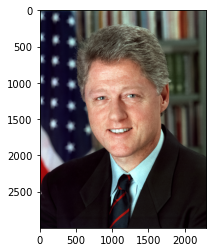

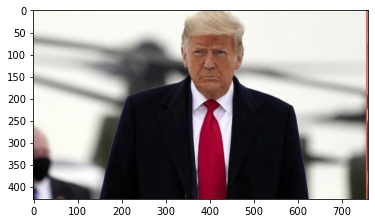

In [7]:
# Reading background and foreground
fg = cv2.imread(fg_path)
bg = cv2.imread(bg_path)

import matplotlib.pyplot as plt
plt.imshow(fg[...,::-1])
plt.show()
plt.imshow(bg[...,::-1])
plt.show()

## Landmark Extraction

To perform face swapping, first we need to localize face region. It can be achieved by detecting a face and its facial landmarks. Landmark prediction algorithm from dlib, used in this tutorial, provides 68 facial landmarks cover chin, eye, eybrows, nose and mouth regions.

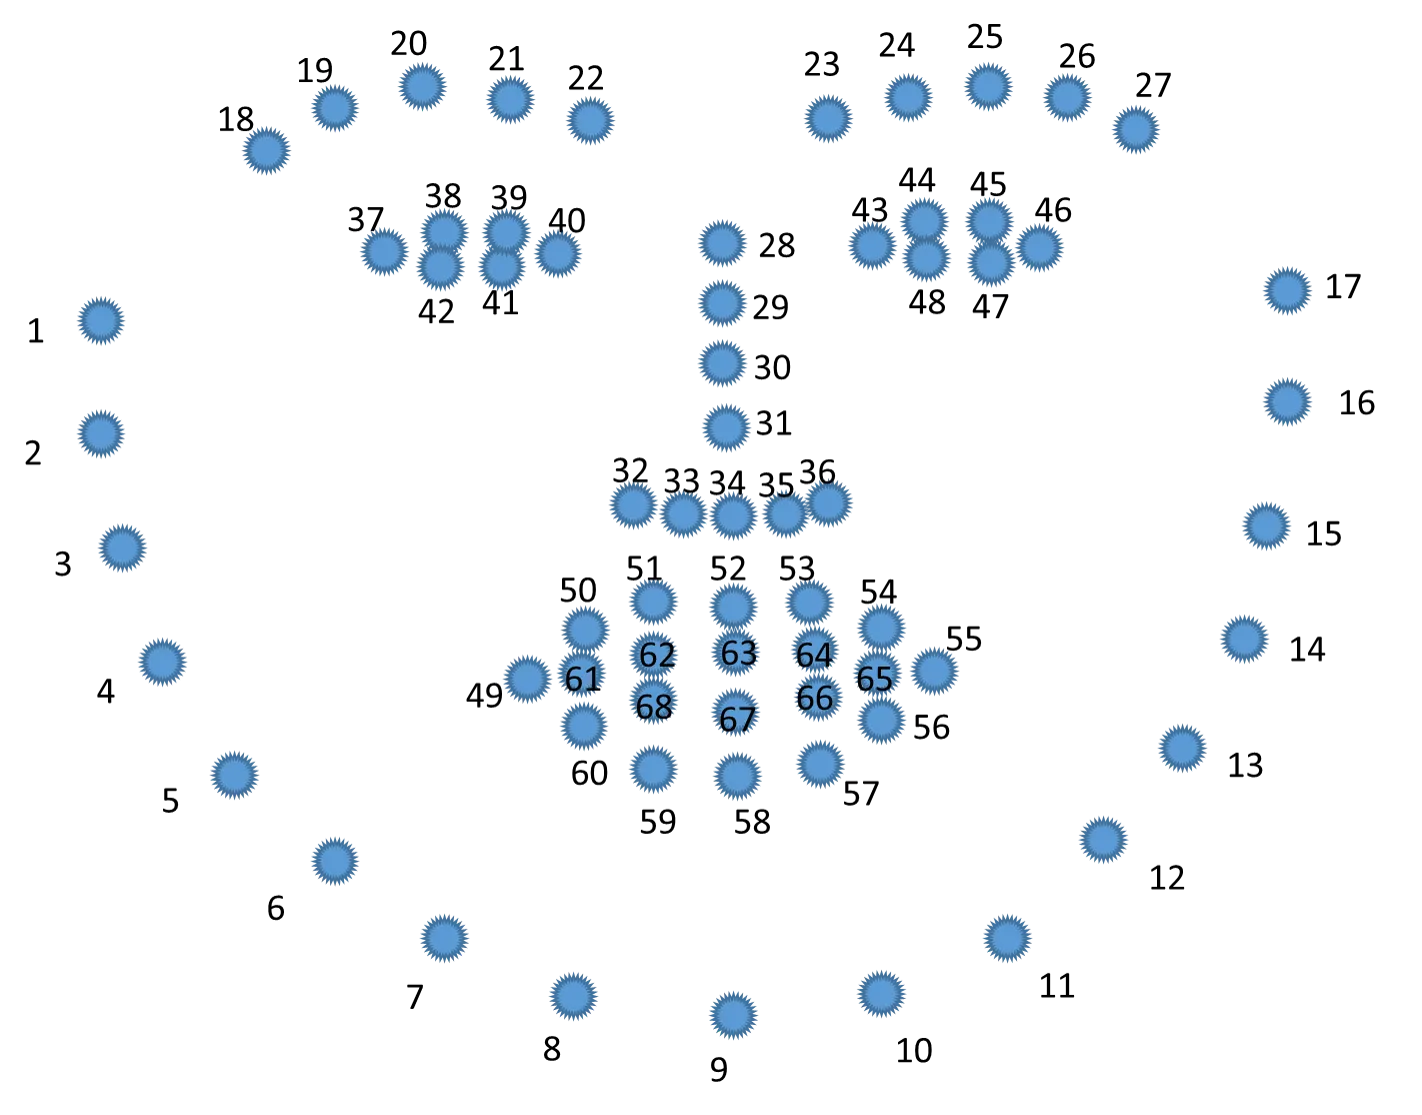

In [8]:
# Face Detector
detector = dlib.get_frontal_face_detector()
# Landmark Detector
predictor = openface.AlignDlib("shape_predictor_68_face_landmarks.dat")

def predict_landmarks(img):
  dets = detector(img, 1)
  if len(dets) < 1:
    return None # Face Not Found
  
  print("Found %d faces" % len(dets))
  d = dets[0]
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  landmarks = predictor.findLandmarks(gray_img, d)
  return np.asarray(landmarks)

In [9]:
fg_landmarks = predict_landmarks(fg)
bg_landmarks = predict_landmarks(bg)

Found 1 faces
Found 1 faces


In [10]:
def visualize_landmarks(img, landmarks, radius=2):
  new_img = np.copy(img)
  h, w, _ = new_img.shape
  for x, y in landmarks:
    x = int(x)
    y = int(y)
    new_img[max(0,y-radius):min(h-1,y+radius),max(0,x-radius):min(w-1,x+radius)] = (255, 0, 0)
  plt.imshow(new_img[...,::-1])
  plt.show()

If you don't see any blue points, increase the radius parameter.

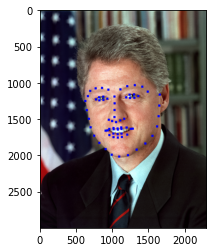

In [11]:
visualize_landmarks(fg, fg_landmarks, radius=15)

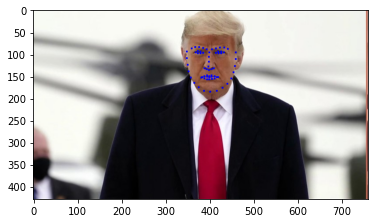

In [12]:
visualize_landmarks(bg, bg_landmarks, radius=2)

**Exercise 1:** Face landmark detection is quite a challenging task on extreme boundary cases (with extreme pose, expression, or lighting). Try out with different images to evaluate the robustness of the landmark detection algorithm.

## Crop face images based on landmarks

Given facial landmarks, face region and be localized and cropped.

In [17]:
from preprocess_img import Preprocess
from PIL import Image
from load_data import *

# read standard landmarks for preprocessing images
lm3D = load_lm3d()

def crop_image(img, landmarks):
  lm5 = np.zeros((5, 2), dtype=np.float32)
  lm5[0] = (landmarks[36] + landmarks[39]) / 2
  lm5[1] = (landmarks[42] + landmarks[45]) / 2
  lm5[2] = landmarks[30]
  lm5[3] = landmarks[48]
  lm5[4] = landmarks[54]
  input_img, lm_new, transform_params = Preprocess(Image.fromarray(img[...,::-1]), lm5, lm3D)

  return input_img, lm_new

In [18]:
fg_cropped, fg_cropped_lm = crop_image(fg, fg_landmarks)
bg_cropped, bg_cropped_lm = crop_image(bg, bg_landmarks)

d:\CV2\assignment3\cv2_2022_assignment3\cv2_2022_assignment3\preprocess_img.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  k,_,_,_ = np.linalg.lstsq(A,b)
d:\CV2\assignment3\cv2_2022_assignment3\cv2_2022_assignment3\preprocess_img.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trans_params = np.array([w0,h0,102.0/s,t[0],t[1]])


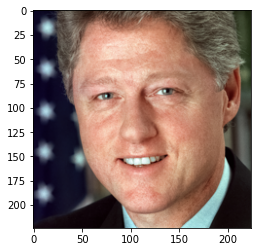

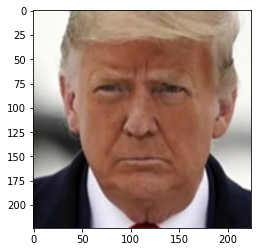

In [19]:
plt.imshow(fg_cropped[0, ..., ::-1])
plt.show()

plt.imshow(bg_cropped[0, ..., ::-1])
plt.show()

## Naive face swapping implementation



One way to naively swap two faces is to detect the face region of the foreground image, crop it and put it on top of the background image.

Found 1 faces


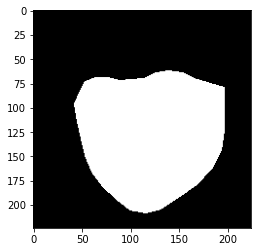

In [20]:
fg_cropped_lm = predict_landmarks(fg_cropped[0]).astype(np.int32)

mask = np.zeros(fg_cropped[0].shape, dtype=np.uint8)
roi_corners = np.array([np.concatenate((fg_cropped_lm[:17], # chin
                                        fg_cropped_lm[17:27][::-1], # eyebrows
                                        ), axis=0)], dtype=np.int32)
channel_count = fg_cropped[0].shape[2]
ignore_mask_color = (255,)*channel_count
cv2.fillPoly(mask, roi_corners, ignore_mask_color)

plt.imshow(mask)
plt.show()

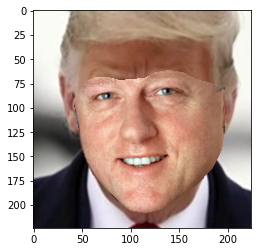

In [21]:
swapped = np.where(mask, fg_cropped[0], bg_cropped[0])
plt.imshow(swapped[..., ::-1])
plt.show()

**Face swap with 3D alignment**

Now, if one can reconstruct a 3D model of two faces and determine their head pose and facial expression, expression and pose of the background face can be applied on the foreground face before merging them together.

In [25]:
from face_swap import FaceSwap
fs = FaceSwap()

ModuleNotFoundError: No module named 'face_decoder'

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.13.1


Please ignore tensorflow errors if a swapped face is returned.

In [ ]:
swapped = fs.swap(fg_cropped, bg_cropped)

0.007932885 0.991364 0.065844 0.96091604
CE (30762, 30730)
Found polygon 551 edges
CE (9547, 9667)
Found polygon 78 edges
solution 0, area 4.79062094
solution 1, area 4.79041515
solution 2, area 4.79041515
solution 3, area 4.88589069
solution 4, area 4.86822446
solution 5, area 4.86822446
solution 6, area 4.99695566
solution 7, area 0.59468630
solution 8, area 0.59468630
solution 9, area 0.58488773
solution 10, area 0.58330777
solution 11, area 0.58326968
solution 12, area 0.58326968
solution 13, area 0.58355257
solution 14, area 0.58885693
solution 15, area 0.60444692
solution 16, area 5.74373500
solution 17, area 5.62663873
solution 18, area 5.58337348
solution 19, area 5.55091789
solution 20, area 5.53081906
solution 21, area 5.51701157
solution 22, area 5.51701157
solution 23, area 5.51703095
solution 24, area 5.51710401
solution 25, area 5.51731102
solution 26, area 5.51041154
solution 27, area 5.50720142
solution 28, area 5.50720142
solution 29, area 5.50721243
solution 30, area 

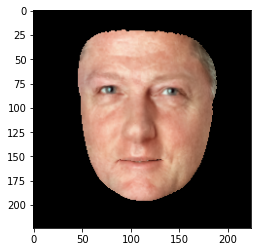

In [ ]:
plt.imshow(swapped)
plt.show()

Now we can combine a swapped face with background.

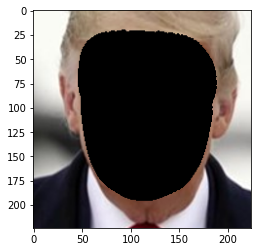

In [ ]:
mask = np.tile(np.any(swapped > 0, axis=2, keepdims=True), (1, 1, 3))

bg = np.copy(bg_cropped[0][..., ::-1])

# Sets all foreground pixel to 0
bg[mask] = 0

plt.imshow(bg)
plt.show()

In [ ]:
output = np.where(mask, swapped, bg)

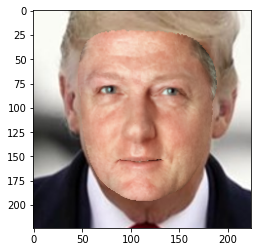

In [ ]:
plt.imshow(output)
plt.show()

## Face Blending

The final step of the face swapping pipeline is to blend swapped face with background.

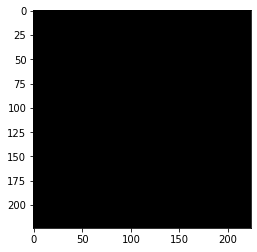

In [ ]:
def blend_imgs_bgr(source_img, target_img, mask):
    ## Your implementation of blending here
    output = np.zeros_like(target_img)

    return output

blended_face = blend_imgs_bgr(output[...,::-1], bg_cropped[0], mask)

plt.imshow(blended_face[...,::-1])
plt.show()